<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221229.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterators

In [2]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns 
from datetime import datetime, date, time, timezone, timedelta
import os
import re

from functools import reduce
from collections import defaultdict

# Customer Analysis

In [3]:
os.listdir()

['.config',
 'sales.csv',
 'online_retail.xlsx',
 '1_order_payments_dataset.csv',
 'online_retail_II.xlsx',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'scanner_data.csv',
 '1_customers_dataset.csv',
 'match_result_test.csv',
 'WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv',
 '1_orders_dataset.csv',
 'sales_vs_discount.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'mall_customers.csv',
 'WA_Fn-UseC_-Telco-Customer-Churn.csv',
 'bz_data_analyis.csv',
 'mock_sales_data.csv',
 'groceries.csv',
 'test.csv',
 'sales_data_with_stores.csv',
 'sample-sales-data.csv',
 'ecommerce-data.csv',
 'sample_data']

In [58]:
df = pd.read_csv('scanner_data.csv').drop('Unnamed: 0', axis = 1)
df.columns = [a.lower() for a in df.columns]
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
df['month'] = df['date'].astype('datetime64[M]')
df['weekday'] = df['date'].dt.weekday
df['day'] = df['date'].dt.day
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,week,month,weekday,day
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13,2015-12-28,2016-01-01,5,2
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46,2015-12-28,2016-01-01,5,2
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35,2015-12-28,2016-01-01,5,2
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59,2015-12-28,2016-01-01,5,2
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88,2015-12-28,2016-01-01,5,2


In [59]:
print(df['date'].min(), df['date'].max())

2016-01-02 00:00:00 2016-12-31 00:00:00


In [60]:
list_weekday = dict(zip(range(7), ['mon','tue','wed','thu','fri','sat','sun']))
df['weekday'] = df['weekday'].apply(lambda x : list_weekday.get(x,x))
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,week,month,weekday,day
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13,2015-12-28,2016-01-01,sat,2
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46,2015-12-28,2016-01-01,sat,2
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35,2015-12-28,2016-01-01,sat,2
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59,2015-12-28,2016-01-01,sat,2
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88,2015-12-28,2016-01-01,sat,2


In [61]:
cnt_cat = df['sku_category'].value_counts().reset_index().rename(columns = {'index':'sku_category', 'sku_category':'cnt'})
cnt_cat['ratio'] = cnt_cat['cnt'].apply(lambda x : round(x/sum(cnt_cat['cnt'])*100,2))
cnt_cat['cat2'] = [b if a >= 2 else 'etc' for a, b in zip(cnt_cat['ratio'], cnt_cat['sku_category'])]
list_cat = dict(zip(cnt_cat['sku_category'], cnt_cat['cat2']))

In [62]:
df = df.assign(cat = df['sku_category'].apply(lambda x : list_cat.get(x,x)))
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,week,month,weekday,day,cat
0,2016-01-02,2547,1,X52,0EM7L,1.0,3.13,2015-12-28,2016-01-01,sat,2,etc
1,2016-01-02,822,2,2ML,68BRQ,1.0,5.46,2015-12-28,2016-01-01,sat,2,etc
2,2016-01-02,3686,3,0H2,CZUZX,1.0,6.35,2015-12-28,2016-01-01,sat,2,0H2
3,2016-01-02,3719,4,0H2,549KK,1.0,5.59,2015-12-28,2016-01-01,sat,2,0H2
4,2016-01-02,9200,5,0H2,K8EHH,1.0,6.88,2015-12-28,2016-01-01,sat,2,0H2


In [63]:
cnt_weekday = df.groupby(['weekday', 'cat'])['quantity'].sum().reset_index()
cnt_weekday['weekday'] = cnt_weekday['weekday'].astype('category')
cnt_weekday['weekday'] = cnt_weekday['weekday'].cat.reorder_categories(['mon','tue','wed','thu','fri','sat','sun'])
cnt_weekday

,weekday,cat,quantity
0,fri,0H2,742.00
1,fri,29A,652.00
2,fri,FEW,573.00
3,fri,FU5,1042.50
4,fri,H15,492.00
...,...,...,...
93,wed,P42,682.00
94,wed,Q4N,522.00
95,wed,R6E,788.00
96,wed,U5F,1354.00


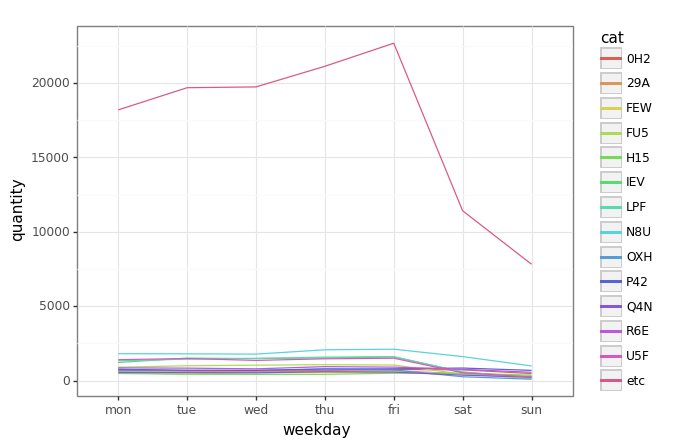

<ggplot: (8752777982202)>

In [64]:
(
    ggplot(cnt_weekday, aes('weekday', 'quantity', color = 'cat', group = 'cat')) +
    gg.geom_line() +
    gg.theme_bw()
)

In [75]:
cnt_day = df.groupby(['month','day', 'cat'])['quantity'].sum().reset_index()
cnt_day = cnt_day.groupby(['day', 'cat'])['quantity'].mean().reset_index()
cnt_day['norm'] = cnt_day['quantity'].apply(lambda x : (x - np.min(x))/(np.max(x)-np.min(x)))
cnt_day

,day,cat,quantity,norm
0,1,0H2,10.090909,NaN
1,1,29A,9.909091,NaN
2,1,FEW,7.090909,NaN
3,1,FU5,16.888889,NaN
4,1,H15,8.727273,NaN
...,...,...,...,...
429,31,P42,15.142857,NaN
430,31,Q4N,7.000000,NaN
431,31,R6E,14.000000,NaN
432,31,U5F,12.142857,NaN


/usr/local/lib/python3.8/dist-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


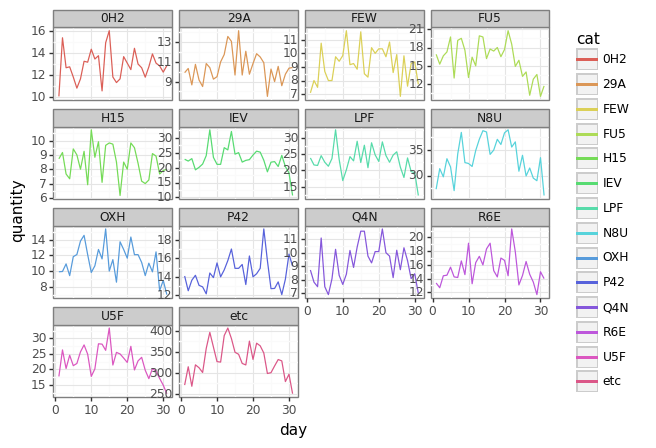

<ggplot: (8752774565882)>

In [77]:
(
    ggplot(cnt_day, aes('day', 'quantity', color = 'cat', group = 'cat')) +
    gg.geom_line() +
    gg.facet_wrap('~cat', scales = 'free_y') +
    gg.theme_bw()
)

# Iterators

In [78]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [79]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}